# Searching for population specific binding sites

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import time
import sys
import os

## Introduction

GRAFIMO is a command-line tool to search DNA motifs represented as Position Weighted Matrices (PWMs) in pangenome variantion graphs (VGs). Scanning VGs allows to search the motifs in thousands of genomes in a single run, considering the genetic variation present within the population of the considered individuals.

GRAFIMO provides an efficient method to study how genetic variation affects DNA motif structure and can help in prioritizing genomic regions, regulating gene expression, which would be missed considering only the reference genome sequence.

In this notebook will be reproduced the analysis of potential population specific binding sites presented in the manuscript "GRAFIMO: variant and haplotype aware motif scanning on pangenome graphs".

The analysis is carried out for three TFs:

- CTCF

- ATF3

- GATA1

### Defining functions used during the analysis

In [2]:
afont = {'fontname': 'Arial'}  # use Arial as font for plots' labels 

In [3]:
def get_tfbs_class(df):
    assert isinstance(df, pd.DataFrame)
    assert "p-value" in list(df.columns)
    assert "coords" in list(df.columns)
    
    df = df.sort_values(["p-value"])
    coords_set = set(df["coords"].tolist())
    df.index = range(len(df))
    hap_bs = list()  # used to study population specific binding sites
    ref_bs = list()  # used to find disrupted binding sites
    
    only_ref = 0
    only_hap = 0
    hap_enha = 0
    hap_weak = 0
    
    start = time.time()
    print("Classifying {} motif occurrences...".format(len(df)))
    
    for c in coords_set:
        wdf = df[df["coords"] == c]
        wdf.reset_index(drop=True, inplace=True)
        if np.all(np.array(wdf.reference) == "ref"):
            only_ref += 1
            ref_bs.append(c)
        elif np.all(np.array(wdf.reference) == "non.ref"):
            only_hap += 1
            hap_bs.append(c)
        elif (np.any(np.array(wdf.reference) == "ref") and 
              np.any(np.array(wdf.reference) == "non.ref")):
            ref_rank = np.where(np.array(wdf.reference) == "ref")[0][0]
            if ref_rank == 0: hap_weak += 1  # ref has highest binding affinity
            else:  # there are occurrences with higher 
                enhanced = np.array(wdf.iloc[:(ref_rank),11].tolist())
                if np.all(enhanced == "non.ref"): hap_enha += 1
                else:
                    raise ValueError(
                        "A problem occurred classifying binding site at {}.".format(c)
                    )
        else:
            raise ValueError(
                        "A problem occurred classifying binding site at {}.".format(c)
                    )  
    stop = time.time()
    print("Classified %d motif occurrences in:\t%.2fs" % (len(df), (stop - start)))
            
    results = [only_ref, only_hap, hap_enha, hap_weak]
    return results, ref_bs, hap_bs


In [4]:
def get_coord(seqname, start, stop, strand):
    assert isinstance(seqname, str)
    assert isinstance(start, str)
    assert isinstance(stop, str)
    assert isinstance(strand, str)
    chrom = seqname.split(":")[0]
    coord = "_".join([chrom, start, stop, strand])
    return coord

In [5]:
def assignPop(samples, popMap, spopMap):
    assert isinstance(samples, str)
    samples = samples.split(",")
    spops = [spopMap[popMap[s]] for s in samples]
    spops = "-".join(spops)
    return spops

In [6]:

def countPopSpec(df, resdict):
    assert "populations" in list(df.columns)
    assert "coords" in list(df.columns)
    coords = set(df.coords.tolist())
    cs = []
    for c in coords:
        pops_list = df[df.coords == c].populations.tolist()
        pops = []
        for pop in pops_list:
            for p in pop.split("-"): pops.append(p)
        if len(set(pops)) == 1: 
            resdict[pops[0]] += 1
            cs.append(c)
    assert len(cs) == len(set(cs))
    return resdict

In [7]:
def plot_pie(pie_chart_data):
    assert isinstance(pie_chart_data, list)
    assert len(pie_chart_data) == 6
    
    #slice labels
    labels = [
        "Common binding sites",
        "AFR", 
        "EUR",
        "AMR", 
        "SAS", 
        "EAS",
    ]
    # slice colors
    colors = [
        "#bfbfbf", 
        "#93d150", 
        "#00b1f1", 
        "#ffc100", 
        "#c10000", 
        "#7030a1"
    ]
    # slice explode
    explode = (0, 0.05, 0.05, 0.05, 0.05, 0.05)
    # plot pie chart
    plt.figure(figsize=(15, 10))
    plt.pie(
        pie_chart_data, explode=explode, colors=colors, autopct='%1.2f%%', 
        shadow=False, startangle=140, textprops={'fontsize': 20}
    )
    plt.legend(labels, loc=(0.8,0.85), prop={'size': 22})
    plt.axis('equal')
    plt.rc('axes', titlesize=22)
    plt.show()

## Recovering 1000 Genomes Project samples information

To assign populations to the analyzed 1000GP samples, we use the info table available [here](https://www.internationalgenome.org/data-portal/sample).

We then create two Python dctionaries from the 1000GP info table, storing the sample to population, and population to superpopulation maps.

In [8]:
# dictionary to map 1000GP samples to their population
samplesinfo_1kgp = pd.read_csv(
    "igsr_samples.tsv",
    sep="\t"
)
samples = samplesinfo_1kgp.iloc[:,0].tolist()
pops = samplesinfo_1kgp.iloc[:,3].tolist()
assert len(samples) == len(pops)
popMap = {}
for i in range(len(samples)): popMap.update({samples[i]:pops[i]})

# dictionary to map 1000GP sample populations to their super population    
spops = samplesinfo_1kgp.iloc[:,5].tolist()
assert len(spops) == len(pops)
spopMap = {}
for i in range(len(pops)):
    if pops[i] not in spopMap.keys():
        spopMap.update({pops[i]:spops[i]})

## CTCF

By analyzing CTCF data, we observed that a large fraction of potential binding sites recovered only on individual haplotypes are population specific. In fact, for CTCF we found that 24.66%, 6.74%, 5.68%, 13.01%, 12.52% of potential CTCF TFBS retrieved on individual haplotype sequences only are specific for AFR, EUR, AMR, SAS and EAS populations, respectively.

In [9]:
ctcf_path = "tf_motifs/CTCF"

In [10]:
# read TSV reports (only significant motif occurrences)
grafimo_restable = "grafimo_out_pop/grafimo_out.tsv"

encff816xlt_pop = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_A549", grafimo_restable),
    sep="\t", index_col=0
)
encff267nyf_pop = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_GM12878", grafimo_restable),
    sep="\t", index_col=0
)
encff015ojg_pop = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_HepG2", grafimo_restable),
    sep="\t", index_col=0
)
encff895hag_pop = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_K562", grafimo_restable),
    sep="\t", index_col=0
)
encff088jwu_pop = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_MCF-7", grafimo_restable),
    sep="\t", index_col=0
)
# put all the results in a single DataFrame
experiments_pop = [encff816xlt_pop, encff267nyf_pop, encff015ojg_pop, encff895hag_pop, encff088jwu_pop]
ctcf_df_pop = pd.concat(experiments_pop)
ctcf_df_pop["populations"] = ctcf_df_pop.apply(lambda x : assignPop(x[12], popMap, spopMap),axis=1)
ctcf_df_pop["coords"] = ctcf_df_pop.apply(lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1)
ctcf_df_pop.reset_index(inplace=True, drop=True)
ctcf_df_pop.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,samples,populations,coords
0,MA0139.1,CTCF,2:231612642-231612803,231612720,231612739,+,29.114754,5.988800e-13,6.040843e-07,TGGCCACCAGGGGGCGCCG,5096,ref,"HG03126,HG01885,HG02429,NA19707,NA18489,HG0345...",AFR-AFR-AFR-AFR-AFR-AFR-EUR-EUR-EAS-EAS-SAS-EU...,2_231612720_231612739_+
1,MA0139.1,CTCF,3:98023327-98023504,98023430,98023411,-,29.049180,8.440969e-13,6.040843e-07,CGGCCACCAGGGGGCGCCA,5096,ref,"HG03126,HG01885,HG02429,NA19707,NA18489,HG0345...",AFR-AFR-AFR-AFR-AFR-AFR-EUR-EUR-EAS-EAS-SAS-EU...,3_98023430_98023411_-
2,MA0139.1,CTCF,7:98021604-98021781,98021693,98021712,+,28.983607,1.014121e-12,6.040843e-07,CGGCCACCAGGGGGCGCCG,5096,ref,"HG03126,HG01885,HG02429,NA19707,NA18489,HG0345...",AFR-AFR-AFR-AFR-AFR-AFR-EUR-EUR-EAS-EAS-SAS-EU...,7_98021693_98021712_+
3,MA0139.1,CTCF,12:108618200-108618398,108618301,108618282,-,28.426230,4.089735e-12,1.218072e-06,CGGCCACCAGGGGGCGCCC,5096,ref,"HG03126,HG01885,HG02429,NA19707,NA18489,HG0345...",AFR-AFR-AFR-AFR-AFR-AFR-EUR-EUR-EAS-EAS-SAS-EU...,12_108618301_108618282_-
4,MA0139.1,CTCF,16:67993308-67993508,67993402,67993421,+,28.426230,4.089735e-12,1.218072e-06,CGGCCACCAGGGGGCGCCC,5094,ref,"HG03126,HG01885,HG02429,NA19707,NA18489,HG0345...",AFR-AFR-AFR-AFR-AFR-AFR-EUR-EUR-EAS-EAS-SAS-EU...,16_67993402_67993421_+


Classifying 29188 motif occurrences...
Classified 29188 motif occurrences in:	32.37s


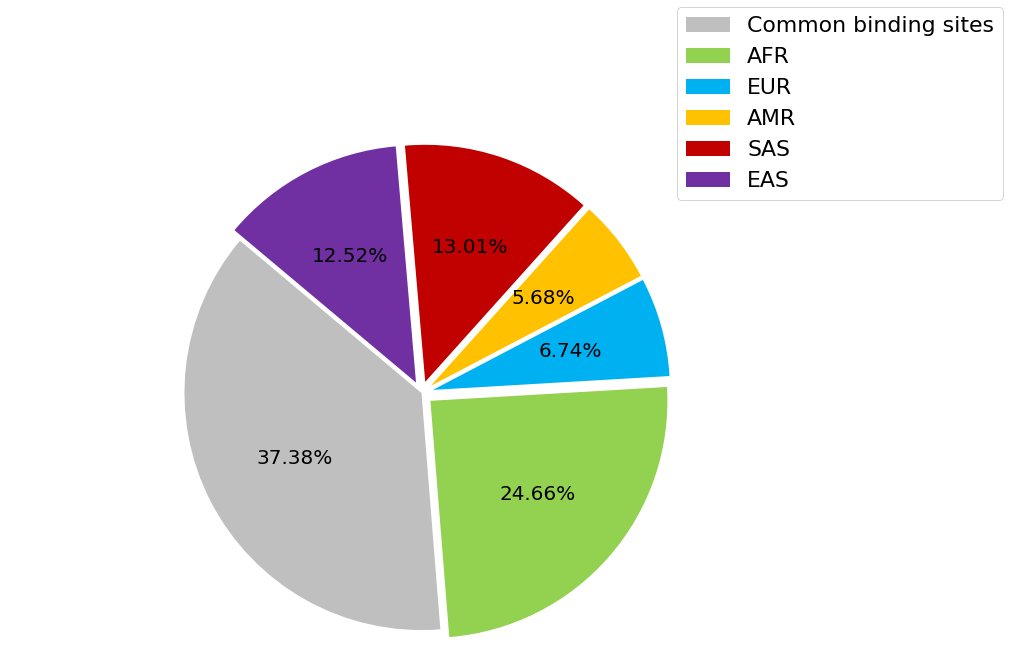

In [11]:
res, ref_bs, hap_bs = get_tfbs_class(ctcf_df_pop)
onlyHap = ctcf_df_pop[ctcf_df_pop.coords.isin(hap_bs)]
popscountdict = {}
for sp in set(spopMap.values()): popscountdict.update({sp:0})
popscountdict.update({"NON REF":len(hap_bs)})
popscountdict = countPopSpec(onlyHap, popscountdict)
pie_chart_data = [
    (popscountdict["NON REF"] - sum(list(popscountdict.values())[:-1])),
    popscountdict["AFR"],
    popscountdict["EUR"],
    popscountdict["AMR"],
    popscountdict["SAS"],
    popscountdict["EAS"]
] 
plot_pie(pie_chart_data)

## ATF3

We observed that also for ATF3 a large fraction of putative binding sites recovered by GRAFIMO only on individual haplotypes are population specific. For ATF3 we found that 19.81%, 3.77%, 7.55%, 19.81%, 19.81% of potential ATF3 TFBS retrieved on individual haplotype sequences only are specific for AFR, EUR, AMR, SAS and EAS populations, respectively

In [12]:
atf3_path = "tf_motifs/ATF3"

In [13]:
# read TSV reports (only significant motif occurrences)
grafimo_restable = "grafimo_out_pop/grafimo_out.tsv"

encff207avv_pop = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_H1", grafimo_restable),
    sep="\t", index_col=0
)
encff753wnt_pop = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_HepG2", grafimo_restable),
    sep="\t", index_col=0
)
encff787gvu_pop = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_K562", grafimo_restable),
    sep="\t", index_col=0
)

# put all the results in a single DataFrame
experiments_pop = [encff207avv_pop, encff753wnt_pop, encff787gvu_pop]
atf3_df_pop = pd.concat(experiments_pop)
atf3_df_pop["populations"] = atf3_df_pop.apply(lambda x : assignPop(x[12], popMap, spopMap),axis=1)
atf3_df_pop["coords"] = atf3_df_pop.apply(lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1)
atf3_df_pop.reset_index(inplace=True, drop=True)
atf3_df_pop.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,samples,populations,coords
0,MA0605.2,ATF3,9:97922178-97922386,97922240,97922228,-,20.12766,4.879815e-08,0.01316,GATGACGTCATC,5096,ref,"HG00273,HG03291,HG00141,HG03898,HG03649,HG0170...",EUR-AFR-EUR-SAS-SAS-EUR-SAS-AFR-EUR-SAS-SAS-AF...,9_97922240_97922228_-
1,MA0605.2,ATF3,9:97922178-97922386,97922228,97922240,+,20.12766,4.879815e-08,0.01316,GATGACGTCATC,5096,ref,"HG00273,HG03291,HG00141,HG03898,HG03649,HG0170...",EUR-AFR-EUR-SAS-SAS-EUR-SAS-AFR-EUR-SAS-SAS-AF...,9_97922228_97922240_+
2,MA0605.2,ATF3,3:124730316-124730556,124730414,124730402,-,20.00000,1.164678e-07,0.01316,GATGACGTCACC,2746,ref,"HG00273,HG03291,HG00141,HG03898,HG03649,HG0170...",EUR-AFR-EUR-SAS-SAS-EUR-SAS-AFR-EUR-AFR-EUR-EA...,3_124730414_124730402_-
3,MA0605.2,ATF3,3:124730316-124730556,124730402,124730414,+,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,2746,ref,"HG00273,HG03291,HG00141,HG03898,HG03649,HG0170...",EUR-AFR-EUR-SAS-SAS-EUR-SAS-AFR-EUR-AFR-EUR-EA...,3_124730402_124730414_+
4,MA0605.2,ATF3,7:100867167-100867407,100867336,100867324,-,20.00000,1.164678e-07,0.01316,GATGACGTCACC,5086,ref,"HG00273,HG03291,HG00141,HG03898,HG03649,HG0170...",EUR-AFR-EUR-SAS-SAS-EUR-SAS-AFR-EUR-SAS-SAS-AF...,7_100867336_100867324_-


Classifying 2400 motif occurrences...
Classified 2400 motif occurrences in:	1.02s


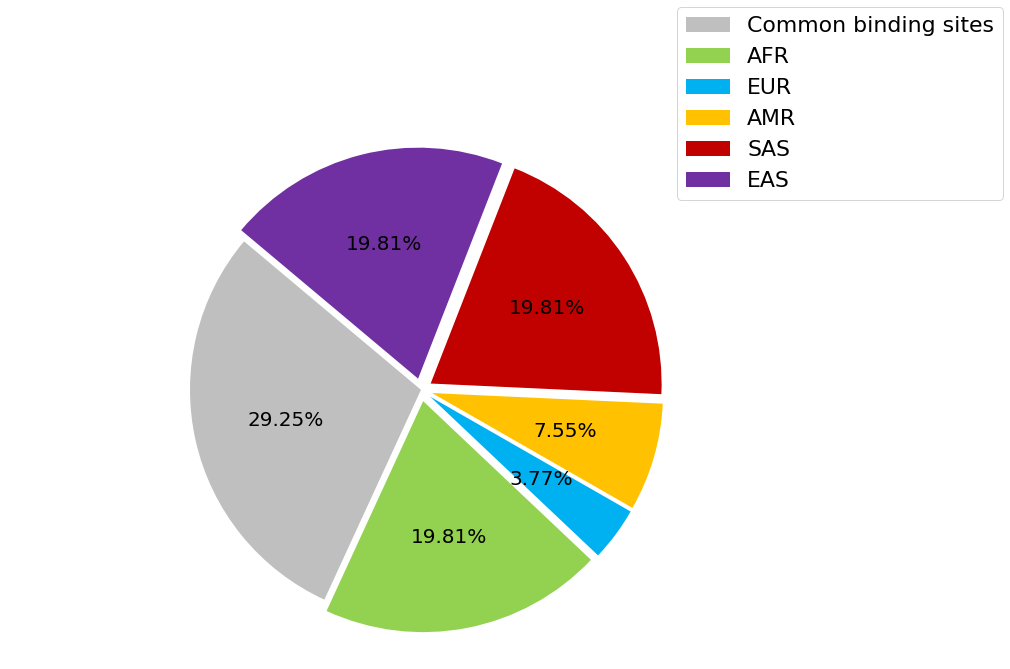

In [14]:
res, ref_bs, hap_bs = get_tfbs_class(atf3_df_pop)
onlyHap = atf3_df_pop[atf3_df_pop.coords.isin(hap_bs)]
popscountdict = {}
for sp in set(spopMap.values()): popscountdict.update({sp:0})
popscountdict.update({"NON REF":len(hap_bs)})
popscountdict = countPopSpec(onlyHap, popscountdict)
pie_chart_data = [
    (popscountdict["NON REF"] - sum(list(popscountdict.values())[:-1])),
    popscountdict["AFR"],
    popscountdict["EUR"],
    popscountdict["AMR"],
    popscountdict["SAS"],
    popscountdict["EAS"]
] 
plot_pie(pie_chart_data)

## GATA1

By analyzing GATA1 potential binding sites recovered only on individual genomes, we observed that a large fraction are population specific. For GATA1 we found that 25.97%, 3.90%, 9.09%, 19.48%, 11.69% of potential putative binding sites retrieved on individual haplotype sequences only are specific for AFR, EUR, AMR, SAS and EAS populations, respectively

In [15]:
gata1_path = "tf_motifs/GATA1"

In [16]:
# read TSV reports (only significant motif occurrences)
encff939odz_pop = pd.read_csv(
    os.path.join(gata1_path, "Cell_line_K562/grafimo_out_pop_ENCFF939ODZ/grafimo_out.tsv"),
    sep="\t", index_col=0
)
encff811yfq_pop = pd.read_csv(
    os.path.join(gata1_path, "Cell_line_K562/grafimo_out_pop_ENCFF811YFQ/grafimo_out.tsv"),
    sep="\t", index_col=0
)

# put all the results in a single DataFrame
experiments_pop = [encff939odz_pop, encff811yfq_pop]
gata1_df_pop = pd.concat(experiments_pop)
gata1_df_pop["populations"] = gata1_df_pop.apply(lambda x : assignPop(x[12], popMap, spopMap),axis=1)
gata1_df_pop["coords"] = gata1_df_pop.apply(lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1)
gata1_df_pop.reset_index(inplace=True, drop=True)
gata1_df_pop.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,samples,populations,coords
0,MA0035.4,GATA1,2:135698955-135699205,135699109,135699098,-,13.100719,0.000001,0.146171,ATCTAATCTAT,4435,ref,"NA07048,HG01632,HG04020,NA20867,HG00097,HG0025...",EUR-EUR-SAS-SAS-EUR-EUR-EUR-AMR-EAS-AFR-EUR-AF...,2_135699109_135699098_-
1,MA0035.4,GATA1,2:135698955-135699205,135699080,135699069,-,13.100719,0.000001,0.146171,ATCTAATCTAT,3417,ref,"NA07048,HG01632,HG04020,NA20867,HG00250,HG0031...",EUR-EUR-SAS-SAS-EUR-EUR-AMR-AFR-EAS-AFR-EUR-AF...,2_135699080_135699069_-
2,MA0035.4,GATA1,2:135698955-135699205,135699084,135699069,-,13.100719,0.000001,0.146171,ATCTAATCTAT,265,non.ref,"HG01857,NA18552,NA18633,NA18950,NA19379,HG0280...",EAS-EAS-EAS-EAS-AFR-AFR-AFR-AFR-EAS-EAS-EAS-AM...,2_135699084_135699069_-
3,MA0035.4,GATA1,2:135698955-135699205,135699012,135699002,-,13.100719,0.000001,0.146171,ATCTAATCTAT,9,non.ref,"NA19210,HG02545,HG02890,HG02946,NA20291,HG0276...",AFR-AFR-AFR-AFR-AFR-AFR-AFR-AFR-AFR,2_135699012_135699002_-
4,MA0035.4,GATA1,2:135698955-135699205,135699028,135699018,-,13.100719,0.000001,0.146171,ATCTAATCTAT,22,non.ref,"NA20845,HG02396,HG02122,HG01850,HG03752,HG0045...",SAS-EAS-EAS-EAS-SAS-EAS-SAS-EAS-EAS-EAS-EAS-EA...,2_135699028_135699018_-


Classifying 886 motif occurrences...
Classified 886 motif occurrences in:	0.46s


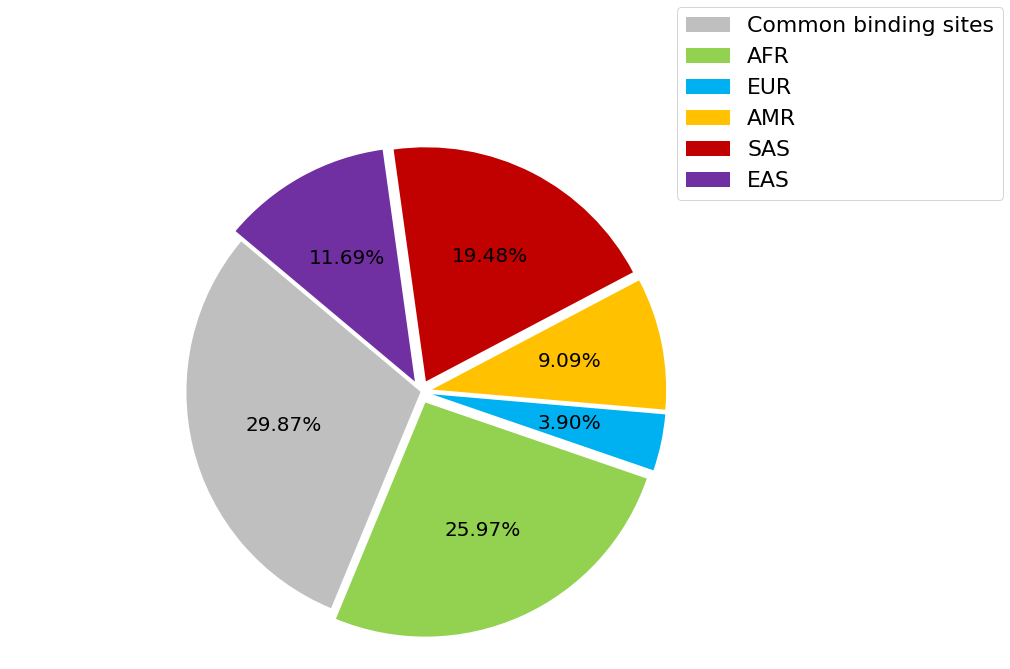

In [17]:
res, ref_bs, hap_bs = get_tfbs_class(gata1_df_pop)
onlyHap = gata1_df_pop[gata1_df_pop.coords.isin(hap_bs)]
popscountdict = {}
for sp in set(spopMap.values()): popscountdict.update({sp:0})
popscountdict.update({"NON REF":len(hap_bs)})
popscountdict = countPopSpec(onlyHap, popscountdict)
pie_chart_data = [
    (popscountdict["NON REF"] - sum(list(popscountdict.values())[:-1])),
    popscountdict["AFR"],
    popscountdict["EUR"],
    popscountdict["AMR"],
    popscountdict["SAS"],
    popscountdict["EAS"]
] 
plot_pie(pie_chart_data)